In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import csv
import sqlite3
import time
from multiprocessing import Pool, cpu_count
import sys

In [2]:
# helper functions
# compute hash of given protein
# compute hashes of multi fasta file
# return which proteins appear in database

### simple -icity calculation: given single protein, find bait neighbourhoods of all related proteins within the 5kb window

In [3]:
def get_list_ids_fromcursor(fetchall):
    return [fetchone[0] for fetchone in fetchall]

In [4]:
def get_permissive_rep(bait_pid):
    conn = sqlite3.connect('genegraph.db')
    cursor = conn.cursor()
    perm_rep = None
    cmd_p = "SELECT p30 FROM clusters WHERE p100 = '%s'" % (bait_pid)
    cursor.execute(cmd_p)
    try:
        perm_rep = cursor.fetchone()[0]
    except:
        pass # to do - this exception should catch nothing
    conn.close()
    return(perm_rep)
# def get_related_baits(perm_rep):
#     conn = sqlite3.connect('genegraph.db')
#     cursor = conn.cursor()
#     cmd_get_strin_rep = "SELECT pid FROM permissive WHERE reppid = '%s'" % (perm_rep)
#     cursor.execute(cmd_get_strin_rep)
#     strin_reps = get_list_ids_fromcursor(cursor.fetchall())
#     p100s_ls = []
#     for strin_rep in strin_reps:
#         cmd_get_p100 = "SELECT pid FROM stringent WHERE reppid = '%s'" % (strin_rep)
#         cursor.execute(cmd_get_p100)
#         p100s = get_list_ids_fromcursor(cursor.fetchall())
#         p100s_ls += p100s    
#     conn.close()
#     return(p100s_ls)

def get_related_baits(perm_rep):
    conn = sqlite3.connect('genegraph.db')
    cursor = conn.cursor()
    cmd_get_strin_rep = "SELECT p100 FROM clusters WHERE p30 = '%s'" % (perm_rep)
    cursor.execute(cmd_get_strin_rep)
    p100s_ls = get_list_ids_fromcursor(cursor.fetchall())
    conn.close()
    return(p100s_ls)

In [31]:
def get_bait_neighbourhood(in_pid):
    conn = sqlite3.connect('genegraph.db')
    cursor = conn.cursor()

    neighbours_set = set()
    cmd_getbaitneighbs = "SELECT p2hash FROM prot2protwindow WHERE p1hash = '%s'" % (in_pid)
    #print(cmd_getbaitneighbs)
    cursor.execute(cmd_getbaitneighbs)
    for neighb_id in get_list_ids_fromcursor(cursor.fetchall()):
        neighbours_set.add(neighb_id) 
    cmd_getbaitneighbs = "SELECT p1hash FROM prot2protwindow WHERE p2hash = '%s'" % (in_pid)
    cursor.execute(cmd_getbaitneighbs)
    for neighb_id in get_list_ids_fromcursor(cursor.fetchall()):
        neighbours_set.add(neighb_id) 
    conn.close()
    return neighbours_set

def get_full_bait_neighbourhood(baits_list):
    neighbours_set = set()
    for bait_id in baits_list:
        neighbours_set.update(get_bait_neighbourhood(bait_id))
    with open("bait_neighbourhood.txt", "w") as outfile:
        for neighbour_id in neighbours_set:
            print(neighbour_id, file=outfile)
    return neighbours_set
        
#neigh_ids = get_bait_neighbourhood("5088749308272be178d0")


def get_p90s(p30_id):
    conn = sqlite3.connect('genegraph.db')
    cursor = conn.cursor()
    cmd = "SELECT p90 FROM clusters WHERE p30 = '%s'" % (p30_id)
    cursor.execute(cmd)
    p90s = get_list_ids_fromcursor(cursor.fetchall())
    conn.close()
    return(p90s)

def get_p100s(p90_id):
    conn = sqlite3.connect('genegraph.db')
    cursor = conn.cursor()
    cmd = "SELECT p100 FROM clusters WHERE p90 = '%s'" % (p90_id)
    cursor.execute(cmd)
    p100s = get_list_ids_fromcursor(cursor.fetchall())
    conn.close()
    return(p100s)


def calc_icity(pid, neighb_set):
    p30=get_permissive_rep(pid)
    if p30 == None:
        return None # to do - fix this issue by making comprehensive permissive clusters
    p90s = get_p90s(p30)
    #print(p90s)
    hits = 0
    print("start calculating icity")
    for p90 in p90s:
        p100s = get_p100s(p90)
        #print(p100s)
        for p100 in p100s:
            if p100 in neighb_set:
                hits += 1
                break
    print("_icity for " + pid + " calculated")
    return [hits / len(p90s), hits, len(p90s)]

In [6]:
# perm_rep_ex = get_permissive_rep("e0f58eed15ffda8a926c")
# related_baits_ex = get_related_baits(perm_rep_ex)
# bait_neighbourhood_ex = get_full_bait_neighbourhood(related_baits_ex)

In [7]:
def calc_icity_pool(pid_set_list):
    pool = Pool(cpu_count())
    results = pool.starmap(calc_icity, iterable = pid_set_list)
    pool.close()
    pool.join()
    
    return results

In [8]:
def final_icity_output(target_p100ids, bait_p100ids):
    bait_neighbourhood_ex = set()
    bait_p30s = []
    for bait_p100id in bait_p100ids:
        perm_rep_ex = get_permissive_rep(bait_p100id)
        bait_p30s.append(perm_rep_ex)
        related_baits_ex = get_related_baits(perm_rep_ex)
        bait_neighbourhood_ex.update(get_full_bait_neighbourhood(related_baits_ex))
    #print(sys.getsizeof(bait_neighbourhood_ex)) # to do - delete later
    icity_arglist = [(target_p100id, bait_neighbourhood_ex) for target_p100id in target_p100ids]
    print(target_p100ids)
    icity_list = calc_icity_pool(icity_arglist)
    print(len(bait_neighbourhood_ex))
    with open("rando_prot_icity_output.csv", "w") as outfile:
        print("target_p100id, icity, numer, denom", file=outfile)
        for i in range(len(icity_arglist)):
            target_p100id = icity_arglist[i][0]
            target_p30id = get_permissive_rep(target_p100id)
            bait_p30ids = str(bait_p30s)
            #print(icity_list)
            try:
                icity, numer, denom = str(icity_list[i][0]), str(icity_list[i][1]), str(icity_list[i][2])
                print(",".join([target_p30id, icity, numer, denom]), file=outfile)
            except:
                pass

In [9]:
transposase_ids = set()
with open("crispricity_candidates.csv", "r") as f:
    next(f)
    lines = f.readlines()
    for line in lines:
        line_sep = line.split(',')
        transposase_ids.add(str(line_sep[0]))

In [10]:
len(transposase_ids)

41090

### tnpb data exploration

In [11]:
def get_all_proteins_set():
    conn = sqlite3.connect('genegraph.db')
    cursor = conn.cursor()
    cmd_get_allprot = "SELECT SUBSTRING(p100, 1, 18) FROM clusters LIMIT 50000000"
    cursor.execute(cmd_get_allprot)
    p100s_ls = get_list_ids_fromcursor(cursor.fetchall())
    conn.close()
    return(set(p100s_ls))

In [12]:
tnpBs_list = []
infile_tnpBs = "tnpBs_in_testdb.p100.txt"
with open(infile_tnpBs, "r") as infile:
    lines = infile.readlines()
    for line in lines:
        p100 = line.split('\n')[0]
        tnpBs_list.append(p100)

In [13]:
len(tnpBs_list)

78873

In [14]:
def get_permissive_rep_pool(bait_p100s):
    pool = Pool(cpu_count())
    results = pool.map(get_permissive_rep, bait_p100s)
    pool.close()
    pool.join()
    return results

In [15]:
perm_reps = get_permissive_rep_pool(tnpBs_list[:100])

In [16]:
def get_related_baits_pool(perm_rep_list):
    pool = Pool(cpu_count())
    results = pool.map(get_related_baits, perm_rep_list)
    pool.close()
    pool.join()
    rv_list = []
    for result in results:
        rv_list += result
    return rv_list

In [17]:
def get_bait_neighb_pool(related_baits):
    pool = Pool(cpu_count())
    results = pool.map(get_bait_neighbourhood, related_baits)
    pool.close()
    pool.join()
    rv_list = []
    for result in results:
        rv_list += result
    return set(rv_list)

In [18]:
def create_tnpB_neighbourhood(bait_p100ids):
    print("get permissive reps")
    perm_reps = get_permissive_rep_pool(bait_p100ids)
    print("get related baits")
    related_baits = get_related_baits_pool(perm_reps)
    print("get bait neighbs")
    bait_neighbs = get_bait_neighb_pool(related_baits)
    print("writing bait neighbs")
    with open("bait_neighbourhood.txt", "w") as outfile:
        for neighbour_id in bait_neighbs:
            print(neighbour_id, file=outfile)
    return bait_neighbs

In [48]:
tic = time.time()
create_tnpB_neighbourhood(tnpBs_list)
toc=time.time()


get permissive reps
get related baits
get bait neighbs
writing bait neighbs


In [53]:
bait_neighb_ids = set()
with open("bait_neighbourhood.txt", "r") as infile:
    lines = infile.readlines()
    for line in lines:
        neighb_id = line.split('\n')[0]
        bait_neighb_ids.add(neighb_id)

In [65]:
def calc_tnpb_icity(pid):
    p30=get_permissive_rep(pid)
    if p30 == None:
        return None # to do - fix this issue by making comprehensive permissive clusters
    p90s = get_p90s(p30)
    #print(p90s)
    hits = 0
    #print("start calculating icity")
    for p90 in p90s:
        p100s = get_p100s(p90)
        #print(p100s)
        for p100 in p100s:
            if p100 in bait_neighb_ids:
                hits += 1
                break
    #print("_icity for " + pid + " calculated")
    return [hits / len(p90s), hits, len(p90s)]
def calc_tnpb_icity_pool(pid_list):
    pool = Pool(cpu_count())
    results = pool.map(calc_tnpb_icity, iterable = pid_list)
    pool.close()
    pool.join()
    return results

In [66]:
def tnpB_icity_output(tnpBs_list, num_runs):
    target_p100ids = list(get_bait_neighb_pool(tnpBs_list))
    icity_arglist = [target_p100id for target_p100id in target_p100ids[:num_runs]] # to do - wastes hella memory
    print("calculating icity for " + str(len(icity_arglist)) + " target genes")
    icity_list = calc_tnpb_icity_pool(icity_arglist)
    count_err = 0
    print("writing -icity to outfile")
    #with open("tnpB_icity_output.csv", "w") as outfile:
    with open("tnpB_icity_output.tmp.csv", "w") as outfile:
        print("target_p100id, icity, numer, denom", file=outfile)
        for i in range(len(icity_arglist)):
            target_p100id = icity_arglist[i]
            target_p30id = get_permissive_rep(target_p100id)
            #print(icity_list)
            try:
                icity, numer, denom = str(icity_list[i][0]), str(icity_list[i][1]), str(icity_list[i][2])
                print(",".join([target_p30id, icity, numer, denom]), file=outfile)
            except Exception as e:
                count_err += 1
                # print(icity_list[i])
                # print(e)
#tnpB_icity_output()

### get all cas1s and cas2s

In [14]:
path_drep = "../drep_genomes/OUTPUT/rep_genomes/"
drep_paths = []
# for directory in os.listdir(path_drep):
#     drep_samples[directory] = path_drep + "/" + directory
for directory in os.listdir(path_drep):
    path_2 = path_drep + directory
    if os.path.isdir(path_2):
        for directory_2 in os.listdir(path_2):
            path_3 = path_2 + "/" + directory_2
            if os.path.isdir(path_3):
                for directory_3 in os.listdir(path_3):
                    path_4 = path_3 + "/" + directory_3 + "/"
                    if os.path.isdir(path_4):
                        for directory_samp in os.listdir(path_4):
                            samp_dir = path_4 + directory_samp
                            if os.path.isdir(samp_dir):
                                drep_paths.append([samp_dir, directory_samp])

In [15]:
def get_castyperfiles(drep_path):
    bucket_path = "gs://durrant/crispestdb/" + drep_path[0][35:] + "/" + drep_path[1] + ".crisprcastyper.domains.tsv.gz"
    command_download = "gsutil cp " + bucket_path + " " + drep_path[0]
    os.system(command_download)
    command_gunzip = "gunzip " + drep_path[0] + "/" + drep_path[1] + ".crisprcastyper.domains.tsv.gz"
    os.system(command_gunzip)
    
def get_castyperfiles_pool(drep_paths):
    pool = Pool(cpu_count())
    results = pool.map(get_castyperfiles, drep_paths)
    pool.close()
    pool.join()

#get_castyperfiles_pool(drep_paths)

In [16]:
drep_cct_paths = []
for drep_path in drep_paths:
    cct_path = drep_path[0] + "/" + drep_path[1] + ".crisprcastyper.domains.tsv"
    drep_cct_paths.append(cct_path)

In [17]:
len(drep_cct_paths)

82377

In [18]:
# # get all cas1s and cas 2s
# count = 0
# for drep_cct_path in drep_cct_paths:
#     try:
#         with open(drep_cct_path, "r") as infile:
#             next(infile)
#             lines = infile.readlines()
#             for line in lines:
#                 line_sep = line.split('\t')
#                 #print(line_sep)
#                 header = line_sep[0]
#                 cas_annot = line_sep[3]
#                 if "Cas1_" in cas_annot:
#                     print(drep_cct_path + "," + header[:20] + "," + cas_annot, file = open("cas1_drep.csv", "a"))
#                 if "Cas2_" in cas_annot:
#                     print(drep_cct_path + "," + header[:20] + "," + cas_annot, file = open("cas2_drep.csv", "a"))
#     except:
#         with open("missed_cct_paths.txt", "a") as outfile:
#             print(drep_cct_path, file=outfile)

In [35]:
cas1s_set, cas2s_set = set(), set()
with open("cas1_drep.csv", "r") as infile:
    lines = infile.readlines()
    for line in lines:
        line_sep = line.split(',')
        cas1_id = line_sep[1]
        cas1s_set.add(cas1_id)
with open("cas2_drep.csv", "r") as infile:
    lines = infile.readlines()
    for line in lines:
        line_sep = line.split(',')
        cas2_id = line_sep[1]
        cas2s_set.add(cas2_id)

In [36]:
len(cas1s_set), len(cas2s_set)

(29791, 41195)

In [37]:
def get_random10kprot():
    conn = sqlite3.connect('genegraph.db')
    cursor = conn.cursor()
    cmd = "SELECT hashid FROM proteins ORDER BY hashid LIMIT 10000"
    cursor.execute(cmd)
    random10kprot = get_list_ids_fromcursor(cursor.fetchall())
    conn.close()
    return(random10kprot)

In [38]:
random_9_proteins = ["00000009ba423c2c0a75", "00000051418dfe799d75", "0000005ef429c9ab9d45", "00000071a6b842424f6a", "000000777af16a869fb0", "000000d70aca3d611da1", "000000e13071a7ecf39f", "0000011dab156def9db5", "00000129e4bc5caa1562"]
final_icity_output(random_9_proteins, list(cas2s_set))

['00000009ba423c2c0a75', '00000051418dfe799d75', '0000005ef429c9ab9d45', '00000071a6b842424f6a', '000000777af16a869fb0', '000000d70aca3d611da1', '000000e13071a7ecf39f', '0000011dab156def9db5', '00000129e4bc5caa1562']
0


In [62]:
cas1_icity_list = []
with open("cas2icity_output.csv", "r") as infile:
    next(infile)
    lines = infile.readlines()
    for line in lines:
        line_sep = line.split(',')
        cas1_icity = line_sep[1]
        cas1_icity_list.append(float(cas1_icity))
cas2_icity_list = []
with open("cas1icity_output.csv", "r") as infile:
    next(infile)
    lines = infile.readlines()
    for line in lines:
        line_sep = line.split(',')
        cas2_icity = line_sep[1]
        cas2_icity_list.append(float(cas2_icity))
rando_prot_icity_list = []
with open("rando_prot_icity_output.csv", "r") as infile:
    next(infile)
    lines = infile.readlines()
    for line in lines:
        line_sep = line.split(',')
        rando_prot_icity = line_sep[1]
        rando_prot_icity_list.append(float(rando_prot_icity))

In [63]:
len(rando_prot_icity_list)

9447

Text(0.5, 1.0, 'cas2-icity scores for 10k random proteins in 80k isolate genomes')

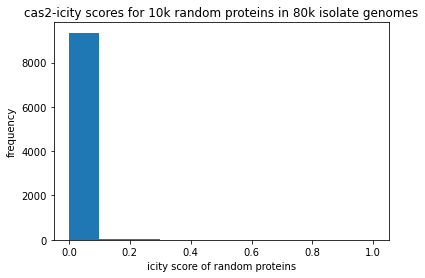

In [64]:
plt.hist(rando_prot_icity_list, bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
plt.xlabel("icity score of random proteins")
plt.ylabel("frequency")
plt.title("cas2-icity scores for 10k random proteins in 80k isolate genomes")

Text(0.5, 1.0, 'cas2-icity scores for all cas1s in 80k isolate genomes')

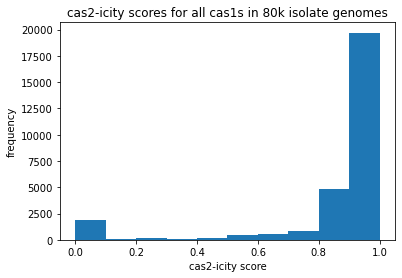

In [55]:
plt.hist(cas1_icity_list, bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
plt.xlabel("cas2-icity score")
plt.ylabel("frequency")
plt.title("cas2-icity scores for all cas1s in 80k isolate genomes")

Text(0.5, 1.0, 'cas1-icity scores for all cas2s in 80k isolate genomes')

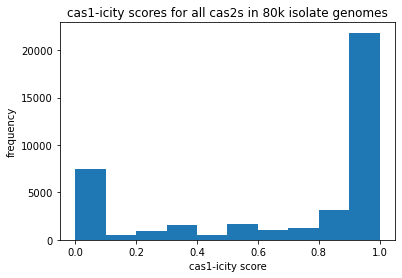

In [56]:
plt.hist(cas2_icity_list, bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
plt.xlabel("cas1-icity score")
plt.ylabel("frequency")
plt.title("cas1-icity scores for all cas2s in 80k isolate genomes")

### explore icity outputs

In [30]:
#final_icity_output(["b9a340f0084638555260"],["e0f58eed15ffda8a926c"])

2097368
[[0.21153846153846154, 11, 52]]


In [32]:
#icity_arglist = [(bait_id, bait_neighbourhood_ex) for bait_id in bait_neighbourhood_ex]

In [31]:
# for i in range(10):
#     print(calc_icity(icity_arglist[i][0], icity_arglist[i][1]))
# icity_arglist[0][0]

NameError: name 'icity_arglist' is not defined

In [32]:
#calc_icity_pool(icity_arglist[:1000])

### calculate unrefined p100, p90, p30 -icity

In [ ]:
def p100icity():
    pass
